In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
from shapely.geometry import Point

In [2]:
town_shp = gpd.read_file('TOWN_MOI_1091016.shp' , encoding = 'utf8')
north_town_shp = town_shp[(town_shp['COUNTYNAME'] == '臺北市') | (town_shp['COUNTYNAME'] == '新北市')]

In [3]:
point_data = pd.read_csv('Taipei_crawl_result.csv' , index_col = 0)
point_data['geometry'] = [Point((0 , 0)) for _ in range(0 , len(point_data))]
for index in range(0 , len(point_data)):
    point_data['geometry'].loc[index] = Point((point_data['lat'].loc[index] ,
                                               point_data['log'].loc[index]))
    
column = '旅店當天價格'
point_data = gpd.GeoDataFrame(point_data)
point_data['{}'.format(column)].fillna(value = 0 , inplace = True)
point_data = gpd.GeoDataFrame(point_data)
point_data.reset_index(inplace = True , drop = True)

In [4]:
poly_data = pd.merge(left = north_town_shp ,
                     right = point_data[[column , '行政區']] ,
                     left_on = 'TOWNNAME' ,
                     right_on = '行政區' ,
                     how = 'outer')
poly_data['{}'.format(column)].fillna(value = 0 , inplace = True)
poly_data = gpd.GeoDataFrame(poly_data)
poly_data.reset_index(inplace = True , drop = True)

# 某些旅店沒有紀律當天價格，但同在該行政區中的其他旅店可能會有紀錄當天價格，因此該旅店還是要記為True
# 若該行政區中沒有任何旅店，或者是有旅店但完全沒有紀錄當天價格，則該旅店則既為False
town_with_record = set(poly_data.query("{} != 0".format(column))['TOWNNAME'])
poly_data['town with record'] = poly_data['TOWNNAME'].apply(lambda x : x in town_with_record)

Text(0.5, 1.0, 'Taipei Hotel Price')

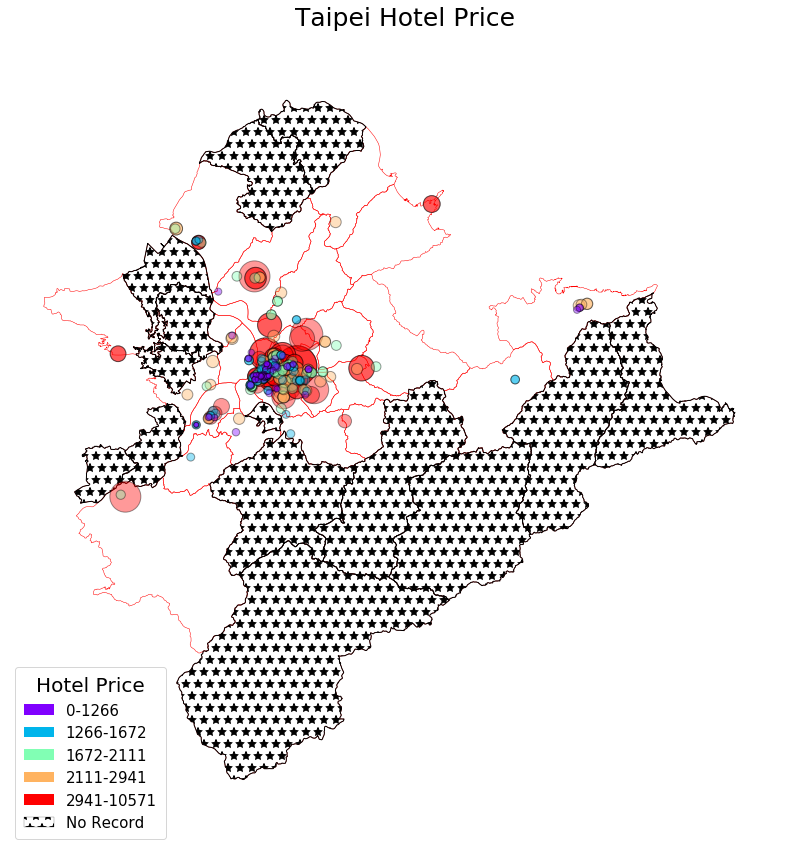

In [5]:
# 簡單繪製行政區
ax = gplt.polyplot(df = north_town_shp ,
                   projection = gcrs.AlbersEqualArea() ,
                   edgecolor = 'red',
                   linewidths = 0.5 ,
                   figsize = (15 , 15))

# 有價格紀錄的旅店，所在的位置與價格會描繪於圖上
gplt.pointplot(df = point_data.query("{} != 0".format(column)) ,
               projection = gcrs.AlbersEqualArea() ,
               ax = ax,
               hue = column,
               scale = column , # 以旅店當天價格作為尺寸映射列
               alpha = 0.4 , # 設置散點透明度
               limits = (5 , 40) , # 設置散點的尺寸範圍
               linewidths = 1 , # 散點輪廓寬度
               edgecolors = 'black' ,
               scheme = mc.Quantiles(point_data.query("{} != 0".format(column))[column]  , k = 5),
               cmap = 'rainbow')

# 無價格紀錄的行政區，會在該行政區以'*'表示
ax = gplt.polyplot(df = poly_data.loc[~poly_data['town with record']] ,
                   projection = gcrs.AlbersEqualArea() ,
                   hatch = '*',
                   edgecolor = 'black',
                   ax = ax)

# 得到mapclassify中BoxPlot的數據分層點
bp = mc.Quantiles(point_data.query("{} != 0".format(column))[column] , k = 5)
bins = [0] + bp.bins.tolist()
cmap = plt.get_cmap('rainbow')

# 製作圖例映射對象列表
LegendElement = [mpatches.Patch(facecolor = cmap(_ / (5-1)) ,
                                label = f'{int(bins[_])}-{int(bins[_+1])}')
                 for _ in range(0 , 5)] + \
                [mpatches.Patch(facecolor = 'none',
                                edgecolor = 'black',
                                linewidth = 0.2,
                                hatch = '*',
                                label = 'No Record')]

# 將制作好的圖例映射對象列表導入legend()中，並配置相關參數
ax.legend(handles = LegendElement ,
          loc = 'lower left',
          fontsize = 15,
          title = 'Hotel Price',
          title_fontsize = 20 ,
          borderpad = 0.6)

# 添加標題
plt.title('Taipei Hotel Price' , fontsize = 25)